In [1]:
%matplotlib inline
%run ../../path_import.py
from plots import *
from training_reparam_os import *
from eubo import *
from model_reparam import *

import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [2]:
data_path = "../gmm_dataset_c5k"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()
_, N, D = Data.shape
K = 3 ## number of clusters
## Model Parameters
MCMC_SIZE = 20
SAMPLE_SIZE = 10
NUM_HIDDEN_LOCAL = 32
## Training Parameters
BATCH_SIZE = 20
NUM_EPOCHS = 500
LEARNING_RATE = 5 * 1e-4
CUDA = torch.cuda.is_available()
PATH = 'ag-os-%dsteps-%dsamples' % (MCMC_SIZE, SAMPLE_SIZE)

DEVICE = torch.device('cuda:0')

In [3]:
# initialization
enc_z = Gibbs_z(K, CUDA, DEVICE)
enc_eta = Enc_eta(K, D, CUDA, DEVICE)
oneshot_eta = Oneshot_eta(K, D, CUDA, DEVICE)
if CUDA:
    enc_eta.cuda().to(DEVICE)
    oneshot_eta.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(oneshot_eta.parameters())+list(enc_eta.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [4]:
# enc_eta.load_state_dict(torch.load('../weights/enc-eta-%s' + PATH))

In [5]:
RESAMPLE = True
DETACH=True
train_cfz_reparam(Eubo_cfz_os_eta, oneshot_eta, enc_eta, enc_z, optimizer, Data, K, NUM_EPOCHS, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE, PATH, CUDA, DEVICE, RESAMPLE=RESAMPLE, DETACH=DETACH)

epoch=0, symKL=546.538, EUBO=-12236.983, ELBO=-23714.291, ESS=1.323 (55s)
epoch=1, symKL=352.922, EUBO=-10978.091, ELBO=-18389.460, ESS=1.373 (59s)
epoch=2, symKL=247.987, EUBO=-10295.907, ELBO=-15503.625, ESS=1.348 (62s)
epoch=3, symKL=192.347, EUBO=-9959.754, ELBO=-13999.049, ESS=1.340 (62s)
epoch=4, symKL=157.671, EUBO=-9748.445, ELBO=-13059.532, ESS=1.367 (59s)
epoch=5, symKL=137.009, EUBO=-9572.940, ELBO=-12450.135, ESS=1.393 (55s)
epoch=6, symKL=120.997, EUBO=-9514.915, ELBO=-12055.848, ESS=1.413 (56s)
epoch=7, symKL=110.049, EUBO=-9482.797, ELBO=-11793.828, ESS=1.425 (63s)
epoch=8, symKL=101.921, EUBO=-9468.672, ELBO=-11609.008, ESS=1.434 (63s)
epoch=9, symKL=95.863, EUBO=-9472.666, ELBO=-11485.781, ESS=1.441 (53s)
epoch=10, symKL=90.696, EUBO=-9502.238, ELBO=-11406.861, ESS=1.446 (54s)
epoch=11, symKL=87.522, EUBO=-9527.891, ELBO=-11365.853, ESS=1.448 (60s)
epoch=12, symKL=84.282, EUBO=-9570.081, ELBO=-11339.996, ESS=1.451 (55s)
epoch=13, symKL=81.574, EUBO=-9613.855, ELBO=-113

In [12]:
torch.save(enc_eta.state_dict(), '../weights/enc-eta-%s' + PATH)
torch.save(oneshot_eta.state_dict(), '../weights/oneshot-eta-%s' + PATH)

In [7]:
BATCH_SIZE_TEST = 50
RESAMPLE= False
DETACH=False
obs, q_eta, q_z, symkl_test, eubo_test, elbo_test = test(Eubo_cfz_os_eta, oneshot_eta, enc_eta, enc_z, Data, K, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, RESAMPLE=RESAMPLE, DETACH=DETACH)

CPU times: user 2.08 s, sys: 31.3 ms, total: 2.12 s
Wall time: 1.76 s


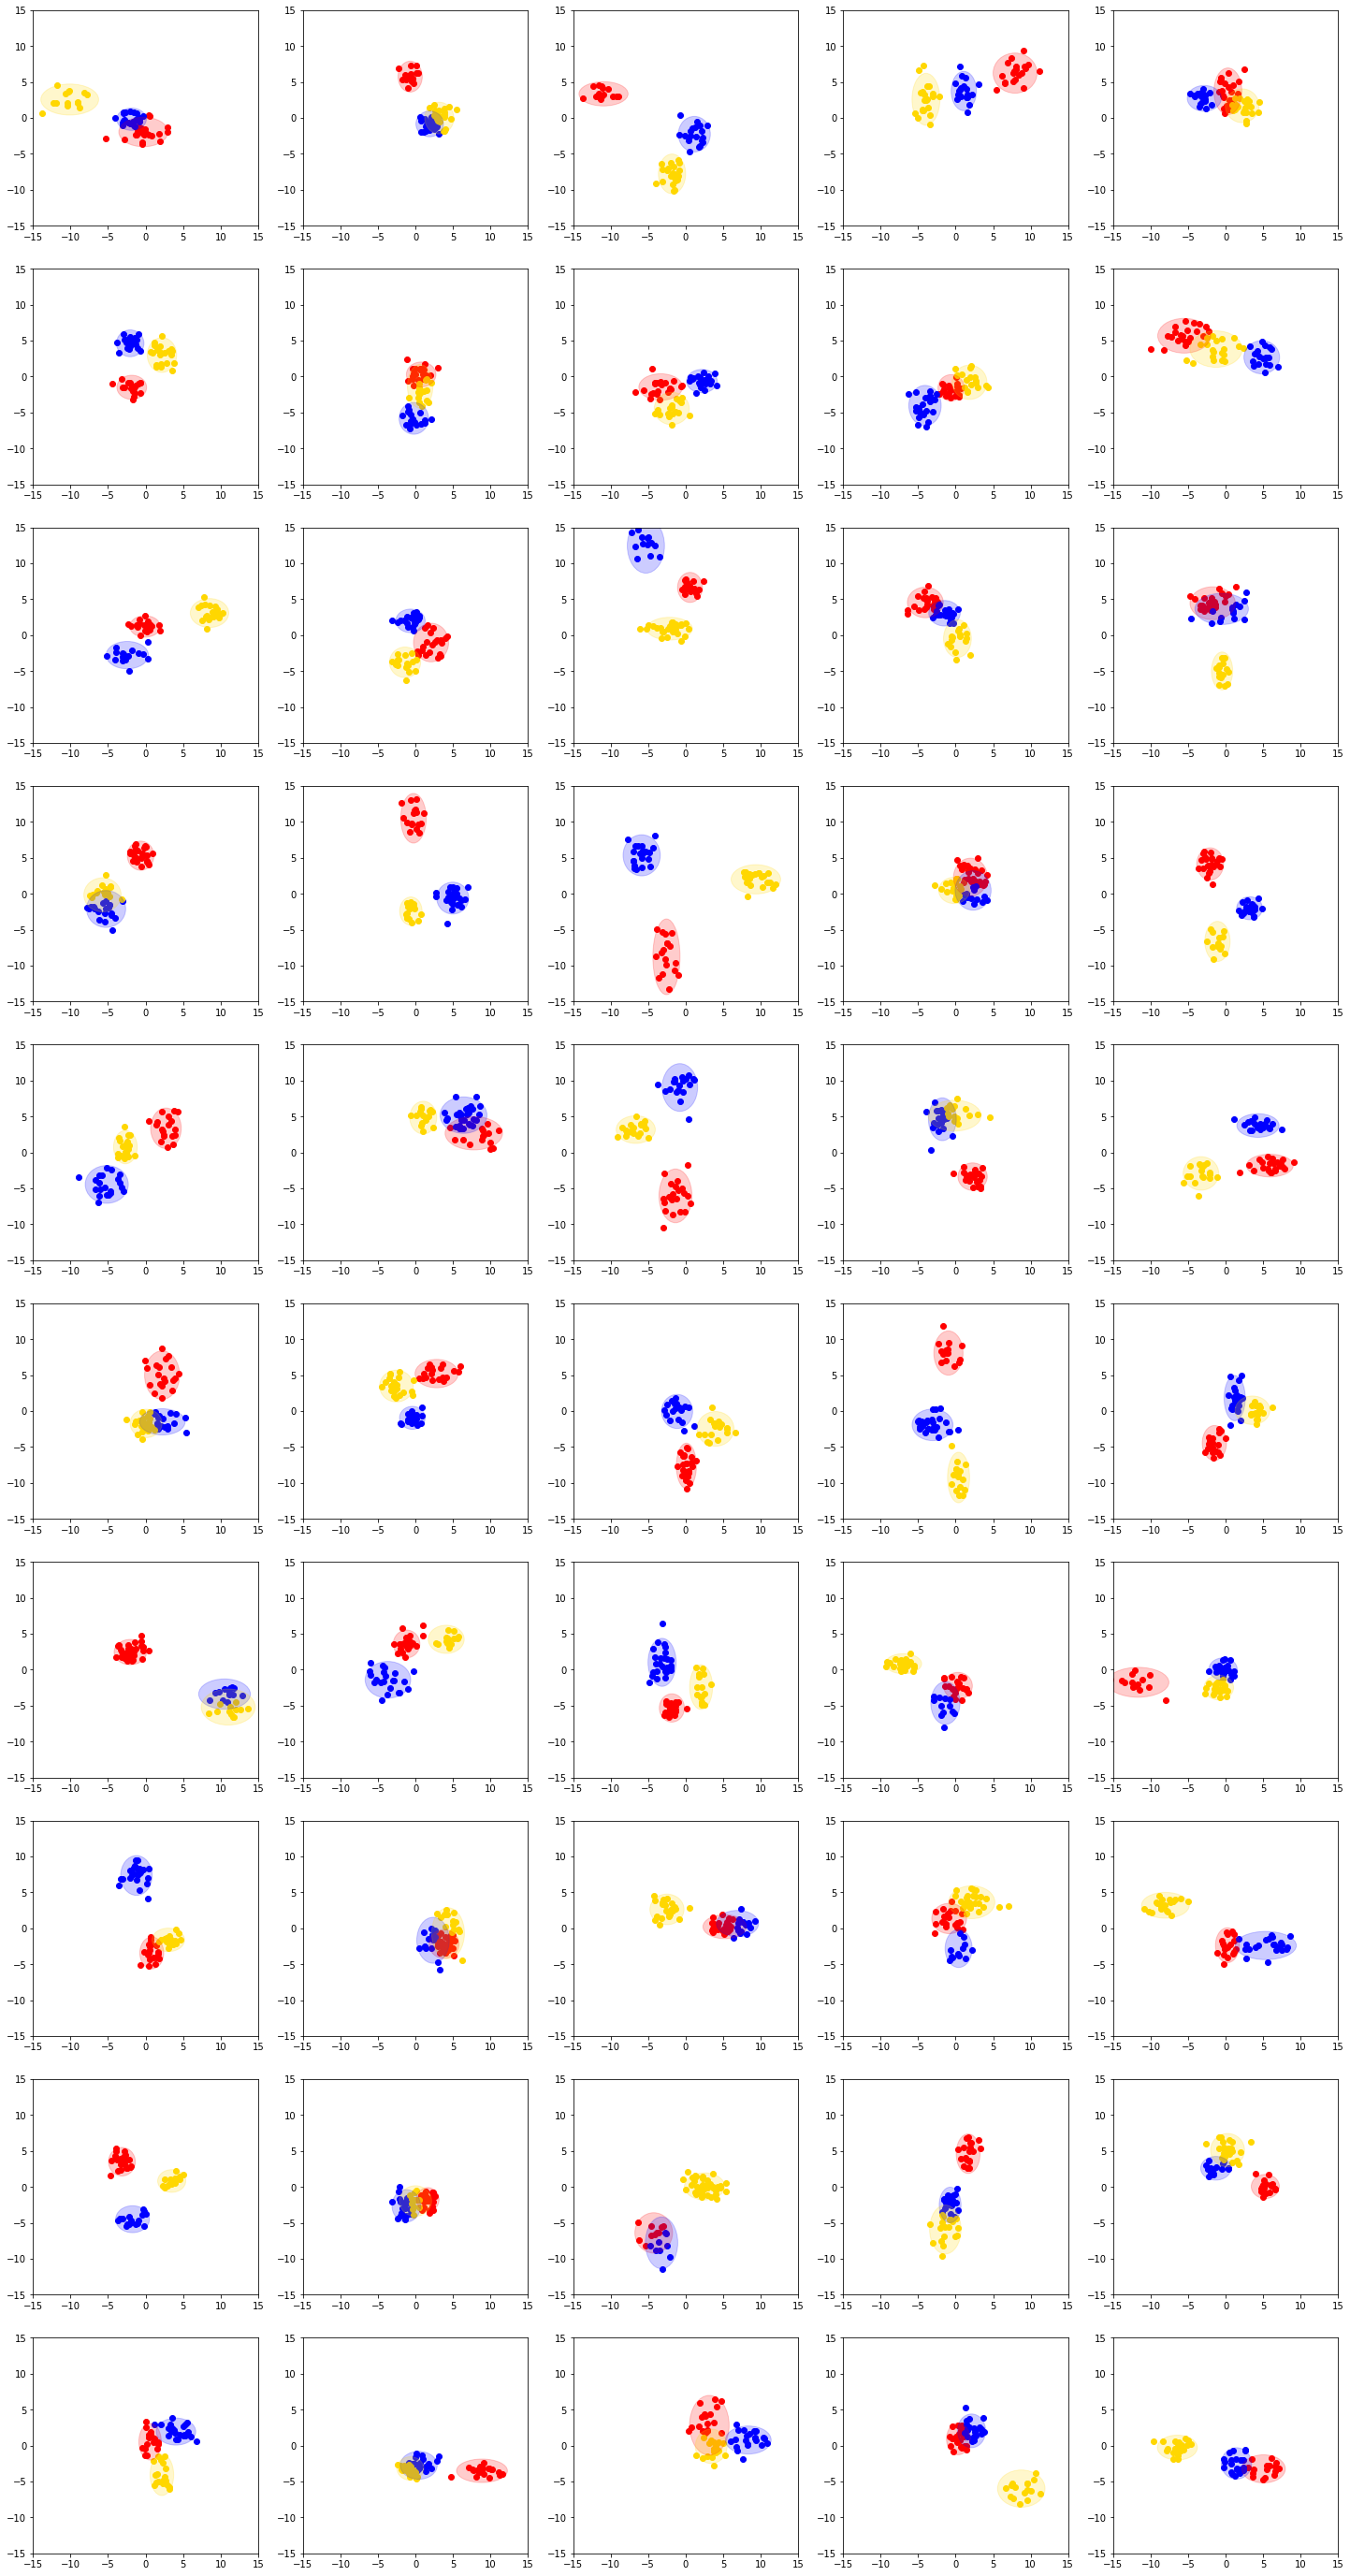

In [8]:
%time plot_samples(obs, q_eta, q_z, PATH)

In [9]:
incremental_gap = symkl_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

Text(0.5, 0, 'Steps')

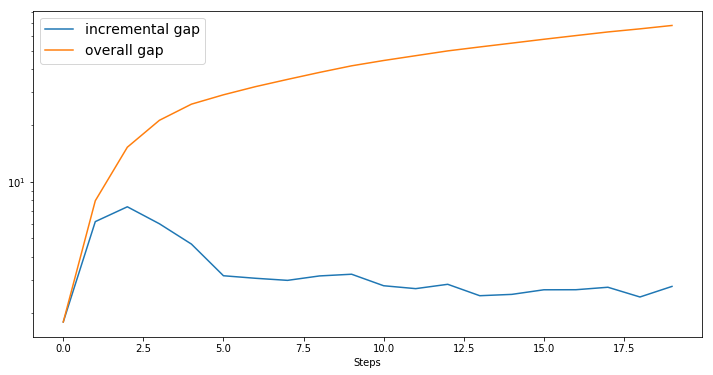

In [10]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')

In [11]:
incremental_gap

array([1.7950927, 6.149955 , 7.375922 , 5.9902368, 4.6679873, 3.1653016,
       3.0685368, 2.991056 , 3.158197 , 3.2248325, 2.7998745, 2.7021966,
       2.8498616, 2.4773798, 2.518323 , 2.6644704, 2.6662784, 2.7485013,
       2.4390562, 2.7767963], dtype=float32)